# Лаб 3. Нейросетевые алгоритмы

Ниже представлены три разных модели рекомендательных систем, которые используют нейронные сети.

Задание:
1. Ознакомится с представленными моделями
2. Для каждой модели подобрать гиперпараметры, чтобы улучшить метрику RMSE.
3. Для DeepFM, помимо гиперпараметров, добавьте хотя бы одно дополнительное поле (можно использовать данные из папки ml-latest-small или напарсить ещё больше данных с помощью links.csv)
4. Соревнование до 1 декабря на бонусные баллы на лучшую метрику RMSE с использованием любой модели (RANDOM_SEED при тестировании будет изменён):
    1. место: 10 баллов
    2. место: 5 баллов
    3. место: 2 балла

Ставим библиотеки

In [ ]:
# об установке pytorch https://pytorch.org/get-started/locally/
%pip install --quiet -U recommenders tensorflow torch tf-slim

Импорты

In [2]:
import pandas as pd
import numpy as np
import os
import cornac
import pandas as pd

# Для разделения выборки на тестовую и обучающую
from recommenders.datasets.python_splitters import python_random_split

# Пакеты для NCF
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset

# Пакеты для BiVAE
from recommenders.models.cornac.cornac_utils import predict
from recommenders.evaluation.python_evaluation import rmse

# Пакеты для DeepFM
from recommenders.models.deeprec.deeprec_utils import prepare_hparams, cal_metric
from recommenders.models.deeprec.models.xDeepFM import XDeepFMModel
from recommenders.models.deeprec.io.iterator import FFMTextIterator


g:\Stud\ИИ\lab3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузка датасета

In [4]:
RANDOM_SEED = 42  # глобальный сид рандома

ratings = pd.read_csv('./ml-latest-small/ratings.csv', delimiter=',')
movies = pd.read_csv('./ml-latest-small/movies.csv', delimiter=',')

# Приводим рейтинги, которые будем предсказывать, к диапазону от 0 до 1
ratings["rating"] = ratings["rating"] / 5

# Делим выборку на тестовую и обучающую
train_ratings, test_ratings = python_random_split(ratings, 0.75, seed=RANDOM_SEED)

# Некоторые алгоритмы (этот алгоритм это NFC) не работают, если в тестовой выборке есть пользователи
# или айтемы, которых не было в тренировочной, так что исключаем их из тестовой выборки
# (это проблема холодного старта, один из недостатков алгоритмов в том чисел матричной факторизации)
test_ratings = test_ratings[test_ratings["userId"].isin(train_ratings["userId"].unique())]
test_ratings = test_ratings[test_ratings["movieId"].isin(train_ratings["movieId"].unique())]

# Neural Collaborative Filtering

![структура NCF](images/NCF.svg)
(иллюстрация взята с [microsoft recommenders](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/ncf_deep_dive.ipynb))

Идея NCF в использовании разложения пользователей и айтемов на вектора признаков, как это делается в матричных разложениях, только вместо линейной комбинации этих векторов использовать нейронную сеть. Модель NCF состоит из двух независимых частей -- GMF части и MLP части (подробнее в оригинальной [статье](https://arxiv.org/abs/1708.05031)), каждый из которых имеет свой собственных вектор признаков.

In [5]:
# Загружаем тренировочный и тестовый датасет обратно в csv, потому что в таком виде их принимает библиотека
if not os.path.isdir(os.path.join('.', r'tmp')):
    os.mkdir(os.path.join('.', r'tmp'))

train_csv_file = os.path.join('.', r'tmp', r'train.csv')
test_csv_file = os.path.join('.', r'tmp', r'test.csv')
train_ratings.sort_values(by='userId').to_csv(train_csv_file, index=False)
test_ratings.sort_values(by='userId').to_csv(test_csv_file, index=False)


In [6]:
# Для этой модели нужно создать специальный объект датасета, который является матрицей юзеров-айтемов
data = NCFDataset(train_file=train_csv_file, test_file=test_csv_file, col_user='userId', col_item='movieId', seed=RANDOM_SEED)

INFO:recommenders.models.ncf.dataset:Indexing .\tmp\train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\tmp\test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file .\tmp\test_full.csv ...
100%|██████████| 610/610 [00:19<00:00, 31.73it/s]
INFO:recommenders.models.ncf.dataset:Indexing .\tmp\test_full.csv ...


In [44]:
# Параметры модели
EPOCHS = 50
BATCH_SIZE = 256

model = NCF(
    n_users=data.n_users, # юзеры
    n_items=data.n_items, # айтемы
    model_type="NeuMF",   # модель NeuMF комбинирует MLP и GMF
    n_factors=10,          # размер вектора признаков
    layer_sizes=[16,8,4], # структура слоёв нейросети
    n_epochs=EPOCHS,      # количество эпох
    batch_size=BATCH_SIZE,# размер батча
    learning_rate=0.000000000001,  # скорость обучения
    verbose=10,           # уровень логирования (логировать каждую 10-ю эпоху)
    seed=RANDOM_SEED      # сид рандома
)

g:\Stud\ИИ\lab3\.venv\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [45]:
model.fit(data)

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [3.45s]: train_loss = 0.693521 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [3.41s]: train_loss = 0.693521 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [3.33s]: train_loss = 0.693521 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [3.40s]: train_loss = 0.693522 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [3.46s]: train_loss = 0.693518 


BEFORE: 0.40024992192379

In [33]:
# Считаем предсказания и метрику RMSE
pred = [model.predict(int(i[1]['userId']), int(i[1]['movieId'])) for i in test_ratings.iterrows()]
initMetx = cal_metric(test_ratings['rating'].to_numpy(), pred, ['rmse'])
print(initMetx)

{'rmse': 0.4080441152620633}


In [46]:
# Считаем предсказания и метрику RMSE
pred = [model.predict(int(i[1]['userId']), int(i[1]['movieId'])) for i in test_ratings.iterrows()]
resMetx = cal_metric(test_ratings['rating'].to_numpy(), pred, ['rmse'])
print(resMetx)

{'rmse': 0.29017236257093815}


In [100]:
print("Improvement:", (1 - (resMetx['rmse'] / initMetx['rmse'])) * 100, "%")

Improvement: 28.887012036780114 %


# Bilateral Variational Autoencoder (BiVAE)

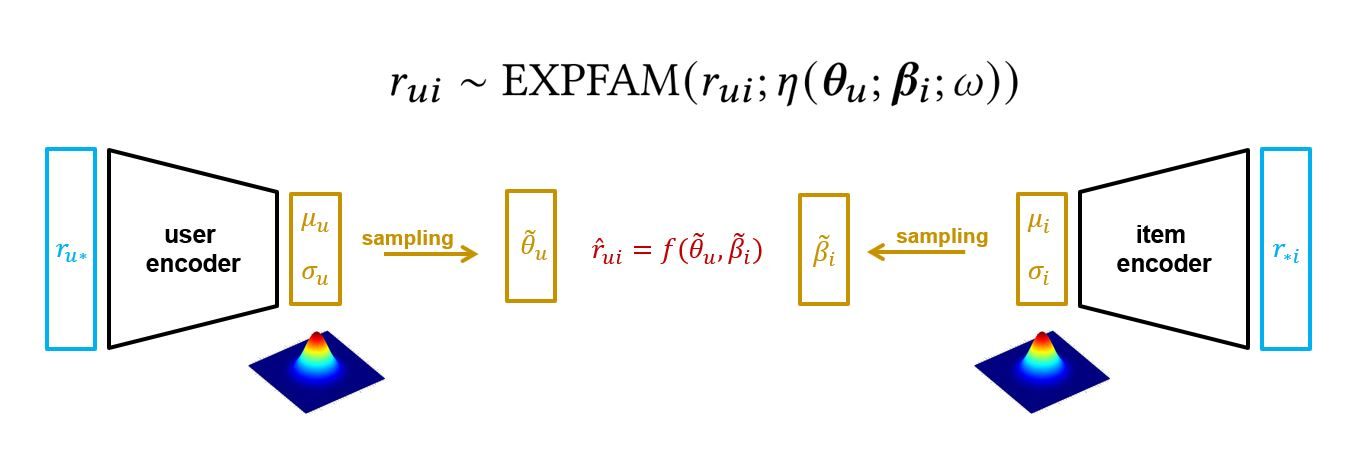

(иллюстрация взята с [microsoft recommenders](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bivae_deep_dive.ipynb))

Модель BiVAE использует нейросеть для формирования векторов признаков пользователей и айтемов, для этого используется Variational Autoencoder $-$ автоэнкодер, который генерирует не сам вектор, а распределение в пространстве признаков. С этим распределением из пространства признаков случайно выбираются значения для обучения.


In [48]:
# Тут тоже есть отдельный объект для представления матрицы матрицу юзеров-айтемов
train_set = cornac.data.Dataset.from_uir(train_ratings.to_numpy(), seed=RANDOM_SEED)

print('Number of users: {}'.format(train_set.num_users))
print('Number of items: {}'.format(train_set.num_items))

Number of users: 610
Number of items: 8787


In [57]:
# Создаём саму модель

EPOCHS = 100
BATCH_SIZE = 128

bivae = cornac.models.BiVAECF(
    k=50,                  # размер пространства вектора признаков
    encoder_structure=[100], # структура промежуточных нейронных слоёв
    act_fn="tanh",         # функция активации
    likelihood="pois",     # функция распределения (у нас распределение Пуассона)
    n_epochs=EPOCHS,       # количество эпох
    batch_size=BATCH_SIZE, # размер батча
    learning_rate=0.000000001,   # скорость обучения
    seed=RANDOM_SEED,      # сид рандома
    use_gpu=False,         # считаем на CPU
    verbose=True           # логирование
)


In [58]:
# Обучаем модель
bivae.fit(train_set)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:46<00:00,  2.17it/s, loss_i=2.6, loss_u=37.2]


In [53]:
# Предсказания для тестовой выборки
predictionsInit = predict(bivae, test_ratings, usercol='userId', itemcol='movieId', predcol="predict")
# Считаем ошибку
initBivaeMetx = rmse(test_ratings, predictionsInit, "userId", "movieId", "rating", "predict")
print(initBivaeMetx)

0.49814771650260764


In [59]:
# Предсказания для тестовой выборки
predictionsRes = predict(bivae, test_ratings, usercol='userId', itemcol='movieId', predcol="predict")
# Считаем ошибку
resBivaeMetx = rmse(test_ratings, predictionsRes, "userId", "movieId", "rating", "predict")
print(resBivaeMetx)

0.25063548558620297


In [99]:
print("Improvement:", (1 - (resBivaeMetx / initBivaeMetx)) * 100, "%")

Improvement: 49.686513200168214 %


## Deep Factorization Machine (DeepFM)

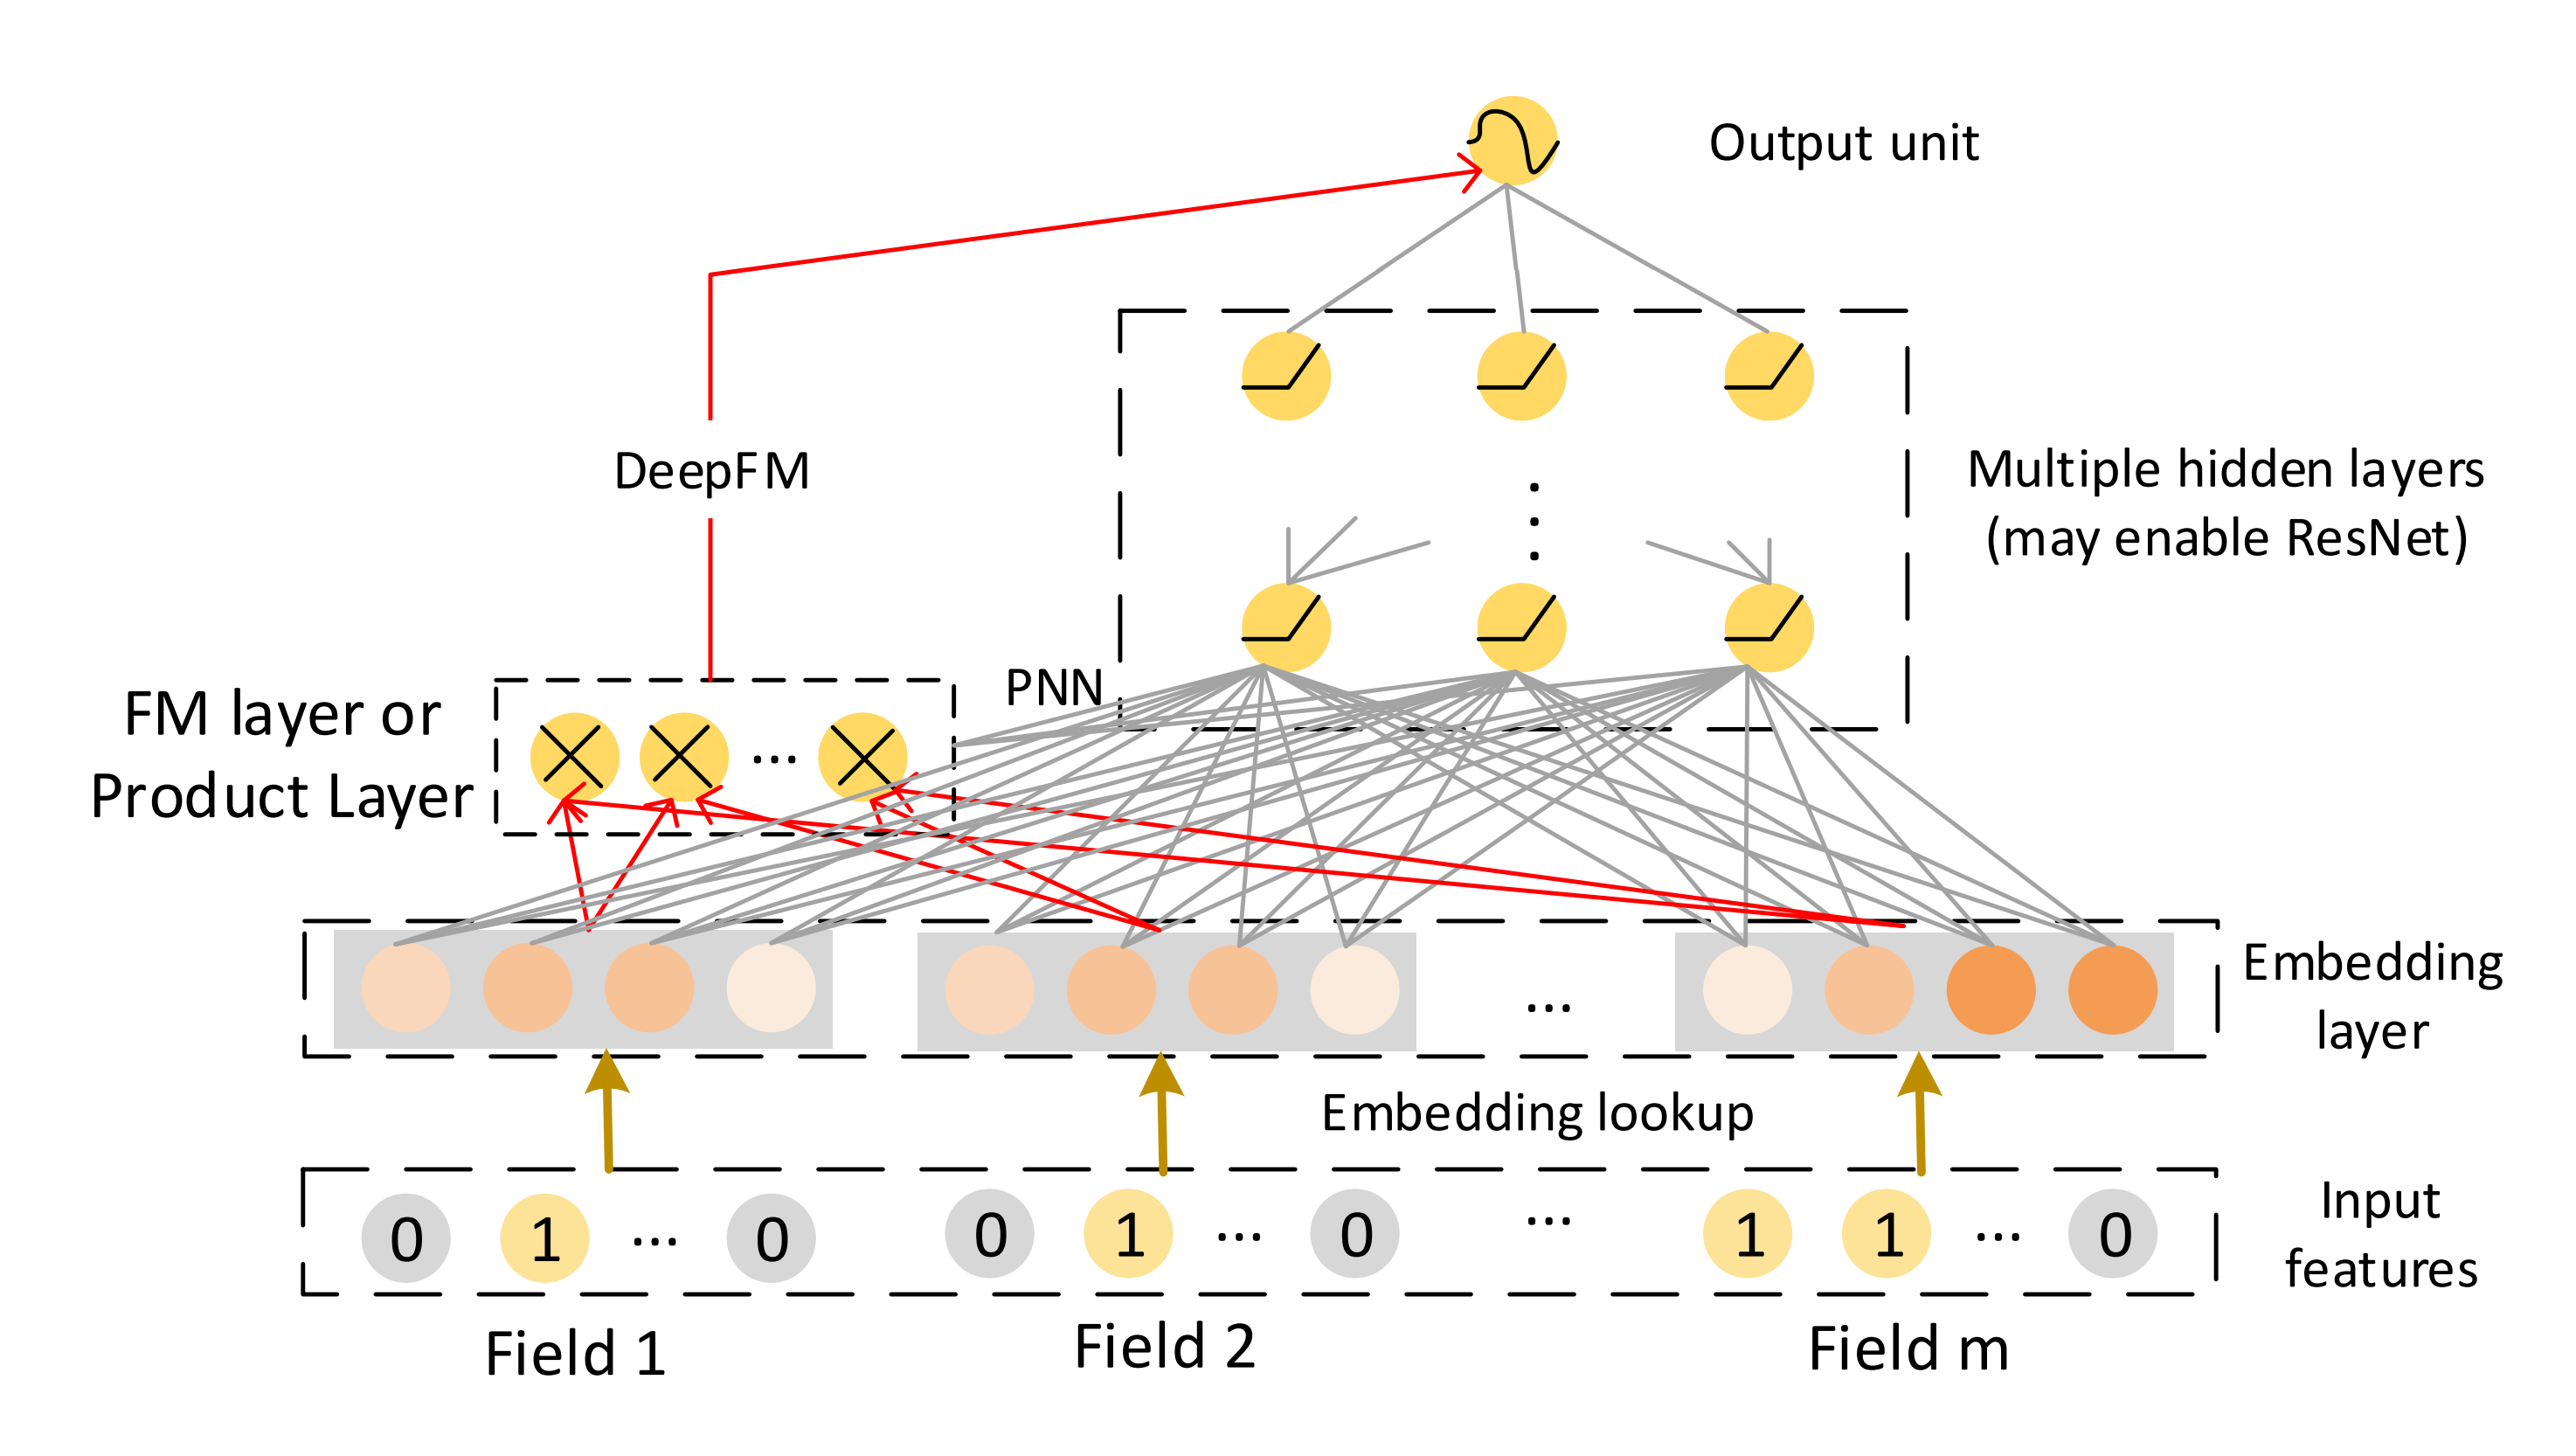
(Иллюстрация взята из статьи [xDeepFM](https://arxiv.org/pdf/1803.05170.pdf))

Это аналог обычной Factorization Machine, где вместе со слоем попарных произведений векторов признаков используется слой глубокой нейронной сети. Исходные признаки в DeepFM кодируются one-hot encoding и делятся на области, такие как пользователи, фильмы, жанр фильма, возраст пользователя и тд.

В нашем случае используется модель [xDeepFM](https://arxiv.org/pdf/1803.05170.pdf), которая отличается от классической [DeepFM](https://arxiv.org/abs/1703.04247) наличием ещё одного дополнительного CIN компонента, для примера мы его выключили.

In [61]:
# Имена файлов конфига и датасетов
yaml_file = os.path.join('.', r'lab3_file', r'xDeepFM.yaml') # в конфиге находятся некоторые полезные настройки модели
train_file = os.path.join('.', r'tmp', r'train')
test_file = os.path.join('.', r'tmp', r'test')

In [62]:
# Количество признаков в каждом поле (пока что полей всего два)
movies_count = len(movies)
users_count = ratings["userId"].max()

In [226]:
movieGenres = movies['genres'].to_dict()

allGenres = set()
for key, value in movieGenres.items():
    allGenres.update(value.split('|'))

genresDict = dict()
i = 1
for item in allGenres:
    genresDict[item] = i
    i += 1

print(allGenres)
print(genresDict)

{'Horror', 'Crime', 'Romance', 'Film-Noir', 'Action', 'Musical', 'Adventure', '(no genres listed)', 'Western', 'Children', 'War', 'Drama', 'Fantasy', 'Sci-Fi', 'IMAX', 'Animation', 'Thriller', 'Documentary', 'Comedy', 'Mystery'}
{'Horror': 1, 'Crime': 2, 'Romance': 3, 'Film-Noir': 4, 'Action': 5, 'Musical': 6, 'Adventure': 7, '(no genres listed)': 8, 'Western': 9, 'Children': 10, 'War': 11, 'Drama': 12, 'Fantasy': 13, 'Sci-Fi': 14, 'IMAX': 15, 'Animation': 16, 'Thriller': 17, 'Documentary': 18, 'Comedy': 19, 'Mystery': 20}


In [241]:
# Функция подготовки данных для Factorization Machine
# Записываем данные в формате
# <оценка> <номер поля>:<номер признака>:<значение признака> <номер поля>:<номер признака>:<значение признака> ...
# значение признака при one-hot encoding обычно 1 (признаки, для которых значение не устанавливается, равны 0)
def prepare_fm_ratings(ratings_data, out_file):
    lines = []
    for i in ratings_data.iterrows():
        row = i[1]
        user = int(row["userId"])
        movieId = row["movieId"]
        movie = movies[movies["movieId"] == movieId].index[0] + 1 # это не очень оптимальная строчка, из-за неё так долго считаются датасеты
        rating = row['rating']

        genres = movies[movies["movieId"] == movieId]['genres'].values[0]
        genre = genres.split('|')[0]
        genreId = genresDict[genre]

        # Пока что тут только два поля -- пользователь и фильм
        lines.append(f"{rating} 1:{user}:1 2:{users_count + movie}:1 3:{users_count + movies_count + genreId}:1")

    with open(out_file, 'w') as file:
        file.write('\n'.join(lines))


In [242]:
# Подготавливаем выборку
prepare_fm_ratings(train_ratings, train_file)
prepare_fm_ratings(test_ratings, test_file)

In [247]:
# Настраиваем гиперпараметры
EPOCHS = 10
BATCH_SIZE = 4096

hparams = prepare_hparams(
    # Ямл файл с базовыми настройками
    yaml_file,
    # Настраиваем размеры датасета
    FEATURE_COUNT=movies_count + users_count + len(allGenres), # суммарное количество признаков
    FIELD_COUNT=3,                            # количество полей
    # Включаем разные части xDeepFM (тут настроено так чтобы оно было обычном DeepFM)
    use_Linear_part=True, # линейный нейрон
    use_FM_part=True,     # квадратичная часть классической FM
    use_CIN_part=False,   # CIN слой (нововведение в xDeepFM)
    use_DNN_part=True,    # DNN слой
    # коэффициенты регуляризации (можно использовать и L1)
    embed_l2=0.0001,        # регуляризатор для слоя признаков
    cross_l2=0.0001,        # регуляризатор для CIN слоя
    layer_l2=0.000001,        # регуляризатор для DNN слоя

    learning_rate=0.002,  # скорость обучения
    epochs=EPOCHS,        # количество эпох
    # всякие размеры слоёв
    batch_size=BATCH_SIZE,
    cross_layer_sizes=[20, 10],
    init_value=0.1,
    layer_sizes=[20,20],
)

print(hparams)

HParams object with values {'use_entity': True, 'use_context': True, 'cross_activation': 'identity', 'user_dropout': False, 'dropout': [0.0, 0.0], 'attention_dropout': 0.0, 'load_saved_model': False, 'fast_CIN_d': 0, 'use_Linear_part': True, 'use_FM_part': True, 'use_CIN_part': False, 'use_DNN_part': True, 'init_method': 'tnormal', 'init_value': 0.1, 'embed_l2': 0.0001, 'embed_l1': 0.0, 'layer_l2': 1e-06, 'layer_l1': 0.0, 'cross_l2': 0.0001, 'cross_l1': 0.0, 'reg_kg': 0.0, 'learning_rate': 0.002, 'lr_rs': 1, 'lr_kg': 0.5, 'kg_training_interval': 5, 'max_grad_norm': 2, 'is_clip_norm': 0, 'dtype': 32, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 4096, 'enable_BN': False, 'show_step': 200000, 'save_model': False, 'save_epoch': 2, 'write_tfevents': False, 'train_num_ngs': 4, 'need_sample': True, 'embedding_dropout': 0.0, 'EARLY_STOP': 100, 'min_seq_length': 1, 'slots': 5, 'cell': 'SUM', 'FIELD_COUNT': 3, 'FEATURE_COUNT': 10372, 'data_format': 'ffm', 'load_model_name': 'you model path',

In [248]:
model = XDeepFMModel(hparams, FFMTextIterator, seed=RANDOM_SEED)

Add linear part.
Add FM part.
Add DNN part.


In [249]:
# Проверяем метрики перед обучением
model.run_eval(test_file)

{'rmse': 0.3004996}

In [250]:
# Обучаем
model.fit(train_file, test_file)
# test датасет тут используется исключительно для печатания метрики

at epoch 1
train info: logloss loss:0.7099507200090509
eval info: rmse:0.2515949
at epoch 1 , train time: 1.6 eval time: 0.5
at epoch 2
train info: logloss loss:0.6409802374086881
eval info: rmse:0.20174241
at epoch 2 , train time: 1.5 eval time: 0.4
at epoch 3
train info: logloss loss:0.6063824484222814
eval info: rmse:0.18841444
at epoch 3 , train time: 1.4 eval time: 0.5
at epoch 4
train info: logloss loss:0.5910206092031378
eval info: rmse:0.17972201
at epoch 4 , train time: 1.4 eval time: 0.4
at epoch 5
train info: logloss loss:0.5830305563776117
eval info: rmse:0.17606817
at epoch 5 , train time: 1.4 eval time: 0.4
at epoch 6
train info: logloss loss:0.5789867012124312
eval info: rmse:0.17464249
at epoch 6 , train time: 1.4 eval time: 0.5
at epoch 7
train info: logloss loss:0.5765095917802108
eval info: rmse:0.17378147
at epoch 7 , train time: 1.4 eval time: 0.5
at epoch 8
train info: logloss loss:0.5747839902576647
eval info: rmse:0.17349352
at epoch 8 , train time: 1.4 eval tim

In [86]:
# Проверяем метрики ещё раз
initDFMMetx = model.run_eval(test_file)
print(initDFMMetx)

{'rmse': 0.20518285}


In [251]:
# Проверяем метрики ещё раз
resDFMMetx = model.run_eval(test_file)
print(resDFMMetx)

{'rmse': 0.17291616}


In [252]:
print("Improvement:", (1 - (resDFMMetx['rmse'] / initDFMMetx['rmse'])) * 100, "%")

Improvement: 15.725821256637573 %


{'Horror', 'Crime', 'Romance', 'Film-Noir', 'Action', 'Musical', 'Adventure', '(no genres listed)', 'Western', 'Children', 'War', 'Drama', 'Fantasy', 'Sci-Fi', 'IMAX', 'Animation', 'Thriller', 'Documentary', 'Comedy', 'Mystery'}
{'Horror': 1, 'Crime': 2, 'Romance': 3, 'Film-Noir': 4, 'Action': 5, 'Musical': 6, 'Adventure': 7, '(no genres listed)': 8, 'Western': 9, 'Children': 10, 'War': 11, 'Drama': 12, 'Fantasy': 13, 'Sci-Fi': 14, 'IMAX': 15, 'Animation': 16, 'Thriller': 17, 'Documentary': 18, 'Comedy': 19, 'Mystery': 20}


In [201]:
print(movies['genres'].to_dict())

{0: 'Adventure|Animation|Children|Comedy|Fantasy', 1: 'Adventure|Children|Fantasy', 2: 'Comedy|Romance', 3: 'Comedy|Drama|Romance', 4: 'Comedy', 5: 'Action|Crime|Thriller', 6: 'Comedy|Romance', 7: 'Adventure|Children', 8: 'Action', 9: 'Action|Adventure|Thriller', 10: 'Comedy|Drama|Romance', 11: 'Comedy|Horror', 12: 'Adventure|Animation|Children', 13: 'Drama', 14: 'Action|Adventure|Romance', 15: 'Crime|Drama', 16: 'Drama|Romance', 17: 'Comedy', 18: 'Comedy', 19: 'Action|Comedy|Crime|Drama|Thriller', 20: 'Comedy|Crime|Thriller', 21: 'Crime|Drama|Horror|Mystery|Thriller', 22: 'Action|Crime|Thriller', 23: 'Drama|Sci-Fi', 24: 'Drama|Romance', 25: 'Drama', 26: 'Children|Drama', 27: 'Drama|Romance', 28: 'Adventure|Drama|Fantasy|Mystery|Sci-Fi', 29: 'Crime|Drama', 30: 'Drama', 31: 'Mystery|Sci-Fi|Thriller', 32: 'Children|Drama', 33: 'Crime|Drama', 34: 'Children|Comedy', 35: 'Comedy|Romance', 36: 'Drama', 37: 'Drama|War', 38: 'Action|Crime|Drama', 39: 'Drama', 40: 'Action|Adventure|Fantasy', 41

In [231]:
movies[movies["movieId"] == 5]['genres'].values[0].split['|'][0]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [240]:
kek = movies[movies["movieId"] == 5]['genres'].values[0]
kek.split('|')

['Comedy']